In [289]:
import numpy as np
import pandas as pd
import pandas_profiling
from StringIO import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def euc_distance(x):
    return np.sqrt(x[0]**2 + x[1]**2)
    
def normalize(angle, min_, max_):
    if angle < min_:
        return angle + 2*np.pi
    if angle > max_:
        return angle - 2*np.pi
    return angle

def get_bin_idx(ang_vel, low=-10.0, high=10.0, step=2.0):
    for i,x in enumerate(np.arange(low, high, step)):
        if ang_vel >= x and ang_vel < (x + step): 
            return i
    else:
        return -1
    
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return normalize(np.arctan2(v1_u[0], v1_u[1]) - np.arctan2(v2_u[0], v2_u[1]), -3.1415, 3.1415)

def read_data(filepath):
    # Read in Data from file
    f_in = open(filepath)
    idx = 0

    control = f_in.readline()
    controls_df = pd.read_csv(StringIO(control), names = ["freq", "p_off", "amp_l", "amp_c", "amp_r"]) 

    duration = f_in.readline()
    durations_df = pd.read_csv(StringIO(duration), names = ["steps"])

    state = f_in.readline()
    states_df = pd.read_csv(StringIO(state), names = ["x", "y", "z"])
    state = f_in.readline()
    while not state in ['\n','\r\n']:
        single_state_df = pd.read_csv(StringIO(state), names = ["x", "y", "z"])
        states_df = states_df.append(single_state_df, ignore_index=True)
        state = f_in.readline()

    all_states = {idx: states_df}

    while True:
        control = f_in.readline()
        if not control: break
        idx += 1
        control_df = pd.read_csv(StringIO(control), names = ["freq", "p_off", "amp_l", "amp_c", "amp_r"])
        controls_df = controls_df.append(control_df, ignore_index=True)

        duration = f_in.readline()
        duration_df = pd.read_csv(StringIO(duration), names = ["steps"])
        durations_df = durations_df.append(duration_df, ignore_index=True)

        state = f_in.readline()
        state_df = pd.read_csv(StringIO(state), names = ["x", "y", "z"])
        state = f_in.readline()
        while not state in ['\n','\r\n']:
            single_state_df = pd.read_csv(StringIO(state), names = ["x", "y", "z"])
            state_df = state_df.append(single_state_df, ignore_index=True)
            state = f_in.readline()
        all_states[idx] = state_df

    all_states_df = pd.concat(all_states)
    f_in.close()
    
    return controls_df, durations_df, all_states_df    

def filter_data(controls_df, durations_df, all_states_df):
    stable_vals, stable_dists, labels = {}, {}, {}

    # Find consistent gaits only
    for idx in controls_df.index:
        item_last = all_states_df.index.levels[1][-1]
        stable_val = angle_between(all_states_df.loc[idx].loc[item_last-11]-all_states_df.loc[idx].loc[item_last-12], 
                                   all_states_df.loc[idx].loc[item_last-10]-all_states_df.loc[idx].loc[item_last-11])
        dist = 0.0
        for st_idx in range(item_last - 9, item_last + 1):
            ang_prev = all_states_df.loc[idx].loc[st_idx-1] - all_states_df.loc[idx].loc[st_idx-2]
            ang_curr = all_states_df.loc[idx].loc[st_idx] - all_states_df.loc[idx].loc[st_idx-1]
            dp_ang = angle_between(ang_prev, ang_curr) 
            dist = np.sqrt((all_states_df.loc[idx].loc[st_idx].x - all_states_df.loc[idx].loc[st_idx-1].x)**2 + 
                            (all_states_df.loc[idx].loc[st_idx].y - all_states_df.loc[idx].loc[st_idx-1].y)**2)

            if not ((dp_ang <= stable_val + 0.0873) 
                    and (dp_ang >= stable_val - 0.0873)):
                all_states_df = all_states_df.drop(idx)
#                 controls_df = controls_df.drop(idx)
#                 durations_df = durations_df.drop(idx)
                labels[idx] = -1
                break
        else:
            stable_vals[idx] = (stable_val*180.0/np.pi)*controls_df.loc[idx].freq
            stable_dists[idx] = dist*controls_df.loc[idx].freq
            labels[idx] = get_bin_idx(stable_vals[idx])
            pass

    stable_dists_df = pd.Series(stable_dists)
    stable_vals_df = pd.Series(stable_vals)
    labels_df = pd.Series(labels)
    controls_df.insert(4, 'vel', stable_dists_df)
    controls_df.insert(4, 'ang_vel', stable_vals_df)
    controls_df.insert(4, 'label', labels_df)
    
    return controls_df, durations_df, all_states_df

filepath = "data/sbb_svm_test_set.txt"
%time controls_df,durations_df,all_states_df=read_data(filepath)
# %timeit controls_df, durations_df, all_states_df = filter_data(controls_df, durations_df, all_states_df)


CPU times: user 11.4 s, sys: 0 ns, total: 11.4 s
Wall time: 11.5 s


In [290]:
%time controls_df, durations_df, all_states_df = filter_data(controls_df, durations_df, all_states_df)

CPU times: user 16.2 s, sys: 4 ms, total: 16.2 s
Wall time: 16.2 s


In [298]:
pwd

u'/home/colin/Repos/tensegrity_physics'

In [300]:
pd.to_pickle(controls_df[['freq','p_off','amp_l','amp_c','amp_r','label']],"data/svm_test_pickle.pkl")

In [302]:
df = pd.read_pickle("./data/svm_test_pickle.pkl")

In [306]:
np.array(df[['freq','p_off','amp_l','amp_c','amp_r']]).shape

(499, 5)

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d69ebac50>]]


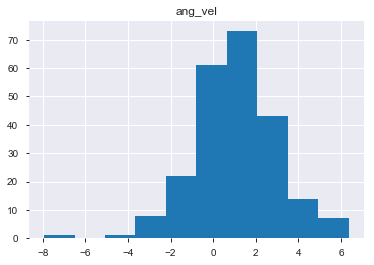

In [291]:
print pd.DataFrame.hist(controls_df, 'ang_vel')

In [292]:
counts = np.histogram(controls_df[(controls_df['ang_vel'] >= -10) & (controls_df['ang_vel'] < 10)]['ang_vel'], 
             bins=10, range=(-10,10))[0]
print counts
print np.sum(counts)
print durations_df['steps'].shape[0]-np.sum(counts)


[  0   1   1  10  43 110  49  15   1   0]
230
269


In [246]:
def get_max_gaits(controls_df):
    rng_bounds = [x*1.0 for x in range(-10, 10, 2)]
    max_vels = [x*0.0 for x in rng_bounds]
    for i,low_bound in enumerate(rng_bounds):
        hi_bound = low_bound + 2.0
        cand_gaits = controls_df[(controls_df['ang_vel'] >= low_bound) & (controls_df['ang_vel'] < hi_bound)]
        if not cand_gaits.empty:
            try:
                idx = np.argmax(cand_gaits['vel'])
                max_vels[i] = cand_gaits.loc[idx]['vel']
            except ValueError as e:
                print cand_gaits
                print cand_gaits.shape
                raise e
    return max_vels


In [256]:
import re

iters = range(50,6000,50)
gp2_xvals, gp2_yvals = [x*1.0 for x in iters], [x*0.0 for x in iters]
for i,itr in enumerate(iters):
    path = os.environ["PRACSYS_PATH"] + "prx_input/maneuvers/parallel_trials/7_svm_norand/" + str(itr) + ".txt"
    f_in = open(path)
    _, _, data, d2 = f_in.readline(), f_in.readline(), f_in.readline().split(": ")[1], f_in.readline().split("]")[0]
    line_1 = [float(a) for a in re.split(" +",re.sub("[\n\[]","",data).lstrip())]
    line_2 = [float(b) for b in re.split(" +", d2.strip())]
    gp2_yvals[i] = sum(line_1) + sum(line_2)
    
#     print re.split(" +", data2)
#     print re.split(" +", data)[2]
#     print re.split(" +", data)[3]
#     print re.split(" +", data)[4]
#     print re.split(" +", data)[]
#     gp_yvals[i] = float(data)
#     gp_xvals[i] = itr

In [249]:
iters = range(50,13300,50)
gp1_xvals, gp1_yvals = [x*1.0 for x in iters], [x*0.0 for x in iters]
for i,itr in enumerate(iters):
    path = os.environ["PRACSYS_PATH"] + "prx_input/maneuvers/parallel_trials/1_mean_std/" + str(itr) + ".txt"
    f_in = open(path)
    _, _, data, d2 = f_in.readline(), f_in.readline(), f_in.readline().split(": ")[1], f_in.readline().split("]")[0]
    line_1 = [float(a) for a in re.split(" +",re.sub("[\n\[]","",data).lstrip())]
    line_2 = [float(b) for b in re.split(" +", d2.strip())]
    gp1_yvals[i] = sum(line_1) + sum(line_2)
    
#     print re.split(" +", data2)
#     print re.split(" +", data)[2]
#     print re.split(" +", data)[3]
#     print re.split(" +", data)[4]
#     print re.split(" +", data)[]
#     gp_yvals[i] = float(data)
#     gp_xvals[i] = itr

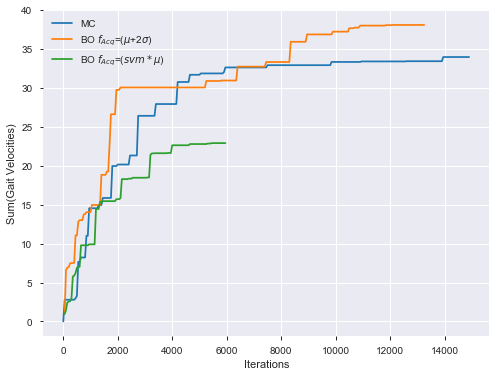

In [257]:
xvals = range(0,14950,50)
yvals = np.sum(map(get_max_gaits, [controls_df[controls_df.index<x] for x in xvals]),axis=1)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(xvals, yvals, label="MC")
ax.plot(gp1_xvals, gp1_yvals, label="BO $f_{Acq}$=($\mu$+2$\sigma$)")
ax.plot(gp2_xvals, gp2_yvals, label="BO $f_{Acq}$=($svm * \mu$)")
ax.set_xlabel("Iterations")
ax.set_ylabel("Sum(Gait Velocities)")
ax.legend()

In [ ]:
print np.max(all_states_df.loc[:].x)
print np.min(all_states_df.loc[:].x)
fig = plt.figure(0)
a,b,_ = plt.hist(all_states_df.loc[:].x, bins=1000)
plt.show()
# print b[np.argmax(a)-5:np.argmax(a)+5]

fig = plt.figure(1)
plt.hist(all_states_df.loc[:].y, bins=1000)
plt.show()

# print controls_df.loc[durations_df.index[2]]
# print controls_df.loc[durations_df.index[3]]
# print controls_df.loc[durations_df.index[4]]
# print controls_df.loc[durations_df.index[5]]
# print controls_df.loc[durations_df.index[6]]
# print controls_df.loc[durations_df.index[10]]

## ------------------ Scratch Work -------------------

In [ ]:
# index = 1598
# print controls_df.loc[index].freq, ", ", controls_df.loc[index].p_off, ", ", \
#         controls_df.loc[index].amp_l, ", ", controls_df.loc[index].amp_r
fig = plt.figure(0, figsize=(8,6))
for idx in [durations_df.index[2]]:
    plt.plot(all_states_df.loc[idx].x, all_states_df.loc[idx].y)
# plt.scatter(all_states_df.loc[index].x, all_states_df.loc[index].y)
plt.xlim(-400,400)
plt.ylim(-400,400)
plt.show()

# fig = plt.figure(1, figsize=(8,6))
# for idx in all_states_df.index.levels[0]:
#     plt.plot(all_states_df.loc[idx].x, all_states_df.loc[idx].y)
# # plt.scatter(all_states_df.loc[index].x, all_states_df.loc[index].y)
# plt.xlim(-400,400)
# plt.ylim(-400,400)
# plt.show()

In [ ]:
states_p = pd.Panel(all_states)
# print states_p.loc[states_p.loc[:,24,"x"] > 100, 0:24, "z"]
itms = states_p.loc[states_p.loc[:,24,"x"] > 100].items
for idx in itms:
    print "IDX: ", idx
    for st_idx in range(14, 24):
        ang_prev = all_states_df.loc[idx].loc[st_idx-1] - all_states_df.loc[idx].loc[st_idx-2]
        ang_curr = all_states_df.loc[idx].loc[st_idx] - all_states_df.loc[idx].loc[st_idx-1]
        print "Angle: ", angle_between(ang_prev, ang_curr)*180.0/np.pi
        print "Dist: ", np.sqrt((all_states_df.loc[idx].loc[st_idx].x - all_states_df.loc[idx].loc[st_idx-1].x)**2 + 
                        (all_states_df.loc[idx].loc[st_idx].y - all_states_df.loc[idx].loc[st_idx-1].y)**2)
        

In [ ]:
state_maxes = []
for idx in all_states_df.index.levels[0]:
    maxx = 0.0
    for st in all_states_df.index.levels[1]:
        dist = np.sqrt((all_states_df.loc[idx].loc[st].x)**2 + 
                        (all_states_df.loc[idx].loc[st].y)**2)
        if dist > maxx: maxx = dist
    state_maxes.append(maxx)


idxs,maxs = [i for i,x in enumerate(state_maxes) if x > 250], [x for i,x in enumerate(state_maxes) if x > 250]

fig = plt.figure(0, figsize=(6,6))
for idx in idxs:
    plt.plot(all_states_df.loc[idx].x, all_states_df.loc[idx].y)
    print controls_df.loc[idx]
    print all_states_df.loc[idx].loc[24]
# plt.scatter(all_states_df.loc[79].x,all_states_df.loc[79].y)
plt.xlim(-500,500)
plt.ylim(-500,500)
plt.show()



In [ ]:
def normalize_sbb_traj(state_df):
    xs, ys = [], []
    degrees = angle_between([0,1],state_df.loc[18])*180/np.pi
    print degrees
    
    s = np.sin(degrees)
    c = np.cos(degrees)

    cx = state_df.loc[18].x
    cy = state_df.loc[18].y
    
    for idx in range(18, state_df.index[-1]):
        x = state_df.loc[idx].x # - state_df.loc[18].x
        y = state_df.loc[idx].y # - state_df.loc[18].y
        xs.append((x-cx)*c - (y-cy)*s )
        ys.append((x-cx)*s + (y-cy)*c )
    return xs, ys

# Search for those points which maximize displacement in chosen directions
desired_directions = [x for x in range(-10.0, 10.0, 2.0)]
allow_thresh = 0.5

sums = []
# for itr in range(1, 201):
max_d = [0] * len(desired_directions)
max_a = [0] * len(desired_directions)
best_indices, best_controls = [0] * len(desired_directions), [0] * len(desired_directions)
for idx in range(0,len(desired_directions)):
    for i, pt in enumerate(durations_df.index):
        if ((stable_vals[i] > desired_directions[idx] - allow_thresh) and 
            (stable_vals[i] < desired_directions[idx] + allow_thresh)):
                if (stable_dists[i] > max_d[idx]):
                    max_d[idx] = stable_dists[i]
                    max_a[idx] = stable_vals[i]
                    best_indices[idx] = pt
                    best_controls[idx] = controls_df.loc[pt]
# if itr == 200:
#     for j, pt in enumerate(best_controls):
#         print pt
#         print model.heading_change_norm[best_indices[j]][0], ", ", \
#                 model.disp_along_heading[best_indices[j]][0], ", ",\
#                 model.box_l[best_indices[j]], ", ",\
#                 model.box_w[best_indices[j]], ", "

# sum = 0
# for item in max_d:
#     try:
#         sum += item[0]
#     except:
#         pass
# sums.append(sum)
# print sums

fig, ax = plt.subplots(1,1, figsize=(8,6))

for i, idx in enumerate(best_indices):
    if isinstance(best_controls[i], int):
        print str(i), ": ", max_a[i], " <-> ", max_d[i], " ---> ", \
                best_controls[i]
    else:
        print str(i), ": ", max_a[i], " <-> ", max_d[i], " ---> ", \
                best_controls[i].freq,",", best_controls[i].p_off,",", \
                best_controls[i].amp_l,",", best_controls[i].amp_r 
#         if i == 1:
        xs, ys = normalize_sbb_traj(all_states_df.loc[idx])
        ax.plot(xs, ys, lw=2, alpha=0.4, label="Dir:{0}".format(desired_directions[i]))
        print max_a[i], ", ", max_d[i], ", ", 10.0, ", ", 10.0
#         ax.scatter(conf[0,0], conf[0,1], s=25)
#         ax.scatter(conf[-1,0], conf[-1,1], s=25)
        
ax.grid(color='lightgray', alpha=0.7)
ax.legend()
plt.show()
        

In [ ]:
near_pt = [0.12079416192, 1.22178624892, 1.61756617313, 1.09627923627, 1.3203864204]
func = lambda x,y: x**y
min_argmin = lambda x,y: (np.argmin(np.sqrt(np.sum(pow(x - y,2), axis=1))), np.min(np.sqrt(np.sum(pow(x - y,2), axis=1))))

stable_dists_df = pd.Series(stable_dists)
# controls_df.insert(5, 'result', stable_dists_df)
# controls_df=controls_df.drop('result', axis=1)

idx, minval = min_argmin(controls_df, near_pt)
print controls_df.loc[idx]
print stable_dists_df.loc[idx]
print all_states_df.loc[idx]
print durations_df.loc[idx]
print minval

In [ ]:
print states_df.loc[maxes.idxmax()]
print np.sqrt(states_df.loc[maxes.idxmax()].x**2 + states_df.loc[maxes.idxmax()].y**2) 

In [ ]:
sin_one = lambda x: np.sin(x)
sin_two = lambda x, n: - n*np.cos(x) + n*np.sin(2*x)

x = np.linspace(0, 8*np.pi, 400)
y_one = map(sin_one, x)
y_two = map(sin_two, x, x*0+1)

fig = plt.figure()
plt.plot(x, y_one)
plt.plot(x, y_two)
plt.show()


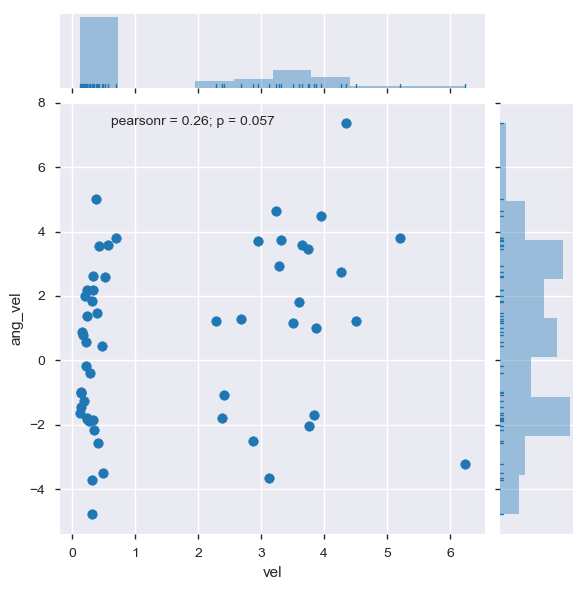

In [113]:
fig = sns.jointplot(x=controls_df[(controls_df['ang_vel']>=-10.0) & (controls_df['ang_vel']<=10.0)]['vel'], 
                    y=controls_df[(controls_df['ang_vel']>=-10.0) & (controls_df['ang_vel']<=10.0)]['ang_vel'], 
                    marginal_kws=dict(bins=10, rug=True))
import matplotlib.ticker as ticker
fig.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
fig.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(2.0))

In [147]:
pandas_profiling.ProfileReport(controls_df)

Number of variables,8
Number of observations,58
Total Missing (%),0.0%
Total size in memory,3.7 KiB
Average record size in memory,65.2 B
Numeric,8
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,58
